## Introduction / Contexte métier

**Secteur** : Crédit à la consommation / Banque  
**Entreprise** : Home Credit  

**Objectif métier** : Fournir des prêts aux clients tout en minimisant le risque de défaut de paiement.  

**Problème identifié** : Certains clients ne remboursent pas leurs prêts, entraînant des pertes financières et augmentant le risque global pour l’entreprise. Ces défauts affectent directement la rentabilité et la stabilité du portefeuille de prêts.  

**Question clé** :  
Comment identifier et prédire les clients présentant un risque élevé de défaut avant l’octroi d’un prêt, afin de prendre des décisions plus sûres et d’optimiser la gestion du risque ?


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pour la séparation train/test et la normalisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Pour le modèle
from sklearn.linear_model import LogisticRegression

# Pour l'évaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

Proportion des TARGET (%) :
 TARGET
0    91.93
1     8.07
Name: proportion, dtype: float64

Montant total des crédits par TARGET :


,TARGET,AMT_CREDIT,AMT_CREDIT_M€,Proportion (%)
0,0,1.703602e+11,170360.23,92.48
1,1,1.384685e+10,13846.85,7.52


Text(0.5, 0, 'TARGET (0 = rembourse, 1 = défaut)')

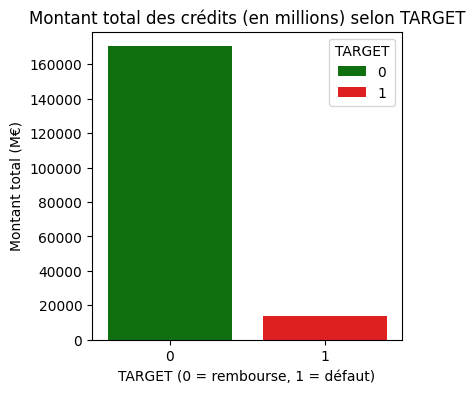

In [2]:
# . visualisation du problème 

application_train = pd.read_csv("application_train.csv")


# 2️Proportion de clients remboursant ou en défaut

proportion = application_train['TARGET'].value_counts(normalize=True) * 100
print("Proportion des TARGET (%) :\n", proportion.round(2))

loss_data = application_train.groupby('TARGET')['AMT_CREDIT'].sum().reset_index()

loss_data['AMT_CREDIT_M€'] = loss_data['AMT_CREDIT'] / 1_000_000

total_sum = loss_data['AMT_CREDIT'].sum()
loss_data['Proportion (%)'] = loss_data['AMT_CREDIT'] / total_sum * 100
loss_data['AMT_CREDIT_M€'] = loss_data['AMT_CREDIT_M€'].round(2)
loss_data['Proportion (%)'] = loss_data['Proportion (%)'].round(2)

#  Afficher le tableau 
print("\nMontant total des crédits par TARGET :")
display(loss_data)

# faire le graphe
plt.figure(figsize=(4,4))
sns.barplot(data=loss_data, x='TARGET', y='AMT_CREDIT_M€', hue='TARGET', dodge=False, palette=['green','red'])

plt.title("Montant total des crédits (en millions) selon TARGET")
plt.ylabel("Montant total (M€)")
plt.xlabel("TARGET (0 = rembourse, 1 = défaut)")


Même si la proportion de crédits en défaut est faible (TARGET=1, 7,5% des montants totaux, soit 13,85 M€), elle représente une perte financière non négligeable. Cela justifie l’analyse des facteurs de risque associés aux clients en défaut. L’objectif est donc de formuler des hypothèses sur les caractéristiques qui pourraient expliquer ces défauts et d’identifier des leviers pour réduire le risque de non-rembourseme

### Hypothèses sur les facteurs de défaut de paiement

1. **age du client**
   - Hypothèse : Les clients très jeunes ou très âgés ont un risque plus élevé de défaut.
   - Variable : `DAYS_BIRTH` (convertie en âge).

2. **Fréquence de changement de téléphone**
   - Hypothèse : Les clients qui changent souvent de téléphone sont moins stables et plus à risque de défaut.
   - Variable : `DAYS_LAST_PHONE_CHANGE`.

3. **Nombre d enfants**
   - Hypothèse : Un plus grand nombre d enfants peut réduire la capacité financière et augmenter le risque de défaut.
   - Variable : `CNT_CHILDREN`.
   - 
4. **Défauts dans le cercle social**
   - Hypothèse : Si beaucoup de personnes dans le cercle social du client ont eu des défauts, le client a plus de chances d’être en défaut.
   - Variables : DEF_30_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE.


5. **Scores de risque de crédit**
   - Hypothèse : Plus le score est bas, plus le risque de défaut est élevé.
   - Variables : EXT_SOURCE_2, EXT_SOURCE_3.

6. **Région de résidence (coût de la vie)**
   - Hypothèse : Les clients vivant dans des régions moins bien notées ont plus de risque de défaut.
   - Variable : `REGION_RATING_CLIENT_W_CITY` ou indicateurs géographiques liés au coût de la région.


In [3]:
# -------------------------------
# Nettoyage ciblé des colonnes
# -------------------------------

import pandas as pd

# Charger le dataset
application_train = pd.read_csv("application_train.csv")

# Liste des colonnes à supprimer
cols_to_drop = [
    # Flags documents inutiles
    'FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21',
    
    # Colonnes de type *_MODE et *_MEDI redondantes
    'ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE',
    'LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI',
    'ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI',
    'LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI',
    'NONLIVINGAREA_MEDI','TOTALAREA_MODE',
    
    # Colonnes catégorielles redondantes
    'FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE',

    # Colonnes liées au bâtiment (AVG)
    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
    'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
    'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',

]

# Supprimer les colonnes
application_train_cleaned = application_train.drop(columns=cols_to_drop, errors='ignore').copy()

# Vérifier le résultat
print("Nombre de colonnes après nettoyage :", application_train_cleaned.shape[1])
application_train_cleaned.head()


Nombre de colonnes après nettoyage : 62


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# verifie presence de doublons

num_duplicates = application_train_cleaned.duplicated().sum()
print(f"Nombre de lignes dupliquées : {num_duplicates}")

# Vérifier le nombre de valeurs manquantes
missing_count = application_train_cleaned.isnull().sum()
missing_percent = (missing_count / len(application_train_cleaned)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_count,
    '% Missing': missing_percent
}).sort_values(by='% Missing', ascending=False)

missing_df.head(30)  # Afficher les 20 colonnes les plus touchées


Nombre de lignes dupliquées : 0


,Missing Values,% Missing
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
YEARS_BUILD_MODE,204488,66.497784
OWN_CAR_AGE,202929,65.990810
BASEMENTAREA_MODE,179943,58.515956
EXT_SOURCE_1,173378,56.381073
NONLIVINGAREA_AVG,169682,55.179164
APARTMENTS_MODE,156061,50.749729
YEARS_BEGINEXPLUATATION_MODE,150007,48.781019
OCCUPATION_TYPE,96391,31.345545


In [5]:
# supprimer car taux de nan supperieur a 40

cols_to_drop_2 = [
    'COMMONAREA_MODE',
    'NONLIVINGAPARTMENTS_AVG',
    'YEARS_BUILD_MODE',
    'OWN_CAR_AGE',
    'BASEMENTAREA_MODE',
    # 'EXT_SOURCE_1',
    'NONLIVINGAREA_AVG',
    'APARTMENTS_MODE',
    'YEARS_BEGINEXPLUATATION_MODE'
]

# Supprimer du dataset nettoyé
application_train_cleaned = application_train_cleaned.drop(columns=cols_to_drop_2, errors='ignore').copy()

# Vérifier le résultat
print("Nombre de colonnes après suppression :", application_train_cleaned.shape[1])
application_train_cleaned.head()


Nombre de colonnes après suppression : 54


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Vérifier le type de chaque colonne
print("Types des colonnes :")
print(application_train_cleaned.dtypes)



Types des colonnes :
SK_ID_CURR                       int64
TARGET                           int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
AMT_GOODS_PRICE                float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                    int64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
FLAG_MOBIL                       int64
FLAG_EMP_PHONE                   int64
FLAG_WORK_PHONE                  int64
FLAG_CONT_MOBILE                 int64
FLAG

In [7]:
# Conversion DAYS_BIRTH (jours négatifs) en âge en années
application_train_cleaned['AGE'] = (-application_train_cleaned['DAYS_BIRTH'] / 365).astype(int)

# Vérifier les valeurs uniques
print("Unique AGE :", application_train_cleaned['AGE'].unique()[:10])  # Affiche seulement les 10 premières pour lisibilité
print("Nombre de valeurs uniques AGE :", application_train_cleaned['AGE'].nunique())

cols_to_check = ['DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

for col in cols_to_check:
    print(f"\nColonne : {col}")
    print("Valeurs uniques (extrait 10 premières) :", application_train_cleaned[col].unique()[:10])
    print("Nombre de valeurs uniques :", application_train_cleaned[col].nunique())

application_train_cleaned.describe()

Unique AGE : [25 45 52 54 46 37 51 55 39 27]
Nombre de valeurs uniques AGE : 50

Colonne : DAYS_LAST_PHONE_CHANGE
Valeurs uniques (extrait 10 premières) : [-1134.  -828.  -815.  -617. -1106. -2536. -1562. -1070.     0. -1673.]
Nombre de valeurs uniques : 3773

Colonne : CNT_CHILDREN
Valeurs uniques (extrait 10 premières) : [0 1 2 3 4 7 5 6 8 9]
Nombre de valeurs uniques : 15

Colonne : REGION_RATING_CLIENT_W_CITY
Valeurs uniques (extrait 10 premières) : [2 1 3]
Nombre de valeurs uniques : 3

Colonne : EXT_SOURCE_2
Valeurs uniques (extrait 10 premières) : [0.26294859 0.62224578 0.55591208 0.65044169 0.32273829 0.35422473
 0.72399985 0.71427929 0.20574729 0.74664363]
Nombre de valeurs uniques : 119831

Colonne : EXT_SOURCE_3
Valeurs uniques (extrait 10 premières) : [0.13937578        nan 0.72956669 0.62122634 0.49206009 0.54065445
 0.75172371 0.36394524 0.65289655 0.17665258]
Nombre de valeurs uniques : 814


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974,43.435968
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295,11.954593
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,43.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,53.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000,69.000000


In [8]:
# Remplacer les valaurs non presente


num_cols_to_impute = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE']

for col in num_cols_to_impute:
    median_value = application_train_cleaned[col].median()
    application_train_cleaned[col] = application_train_cleaned[col].fillna(median_value)

import missingno as msno

# # Liste des colonnes à visualiser
# cols_subset = ['AGE', 'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN','REGION_RATING_CLIENT_W_CITY','EXT_SOURCE_2', 'EXT_SOURCE_3']

# plt.figure(figsize=(10,5))
# msno.matrix(application_train_cleaned[cols_subset])
# plt.show()


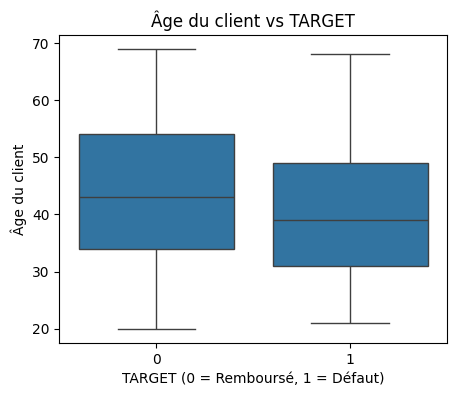

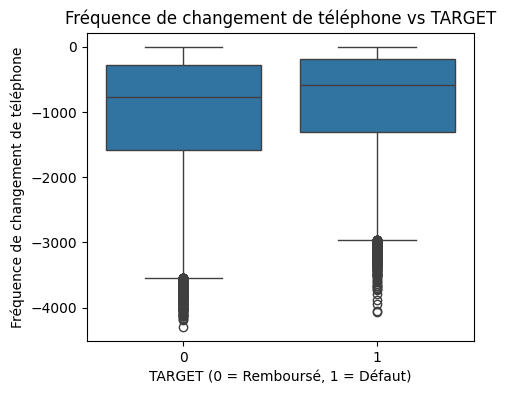

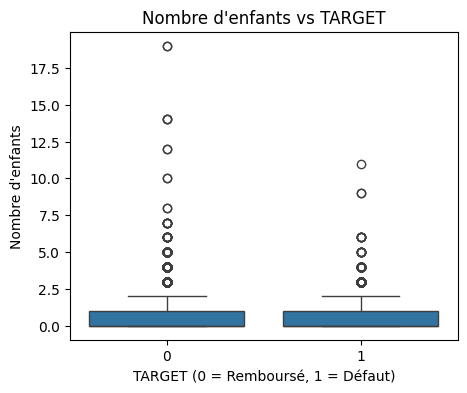

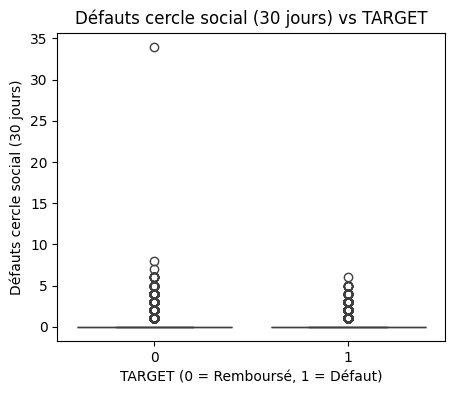

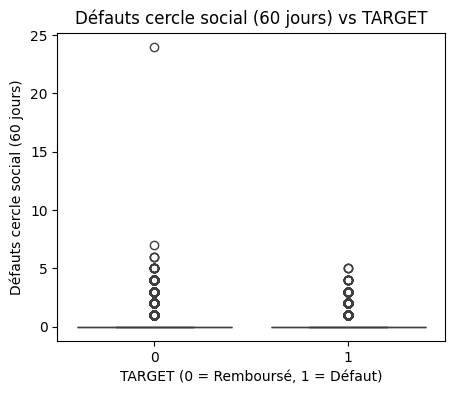

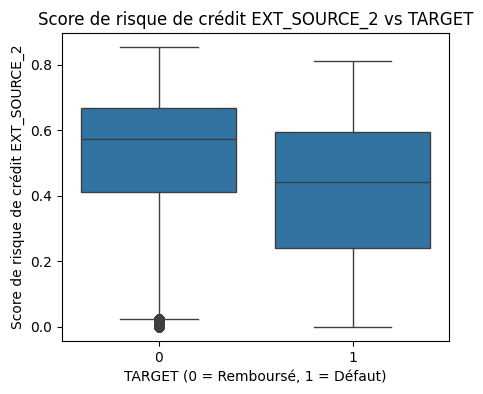

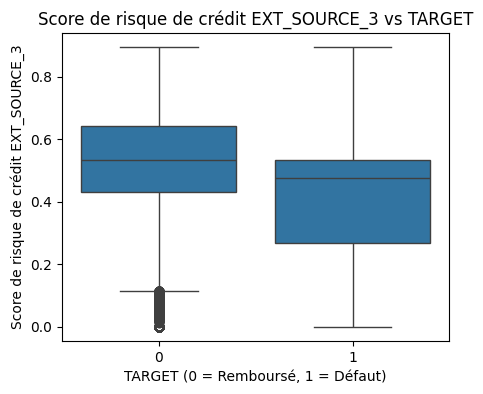

In [9]:
# Import des librairies
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# Variables ciblées
hypotheses_vars = {
    "Âge du client": "AGE",
    "Fréquence de changement de téléphone": "DAYS_LAST_PHONE_CHANGE",
    "Nombre d'enfants": "CNT_CHILDREN",
    "Défauts cercle social (30 jours)": "DEF_30_CNT_SOCIAL_CIRCLE",
    "Défauts cercle social (60 jours)": "DEF_60_CNT_SOCIAL_CIRCLE",
    "Score de risque de crédit EXT_SOURCE_2": "EXT_SOURCE_2",
    "Score de risque de crédit EXT_SOURCE_3": "EXT_SOURCE_3"
}

# Conversion DAYS_BIRTH en âge (années)
application_train_cleaned['AGE'] = (-application_train_cleaned['DAYS_BIRTH']) // 365

# Boucle pour tracer les graphiques
for name, var in hypotheses_vars.items():
    plt.figure(figsize=(5,4))
    
    # Si la variable est numérique continue, on utilise boxplot
    sns.boxplot(x='TARGET', y=application_train_cleaned[var], data=application_train_cleaned)
    
    plt.title(f"{name} vs TARGET")
    plt.xlabel("TARGET (0 = Remboursé, 1 = Défaut)")
    plt.ylabel(name)
    plt.show()


# Analyse des hypothèses sur le risque de défaut

**1. Âge du client**
- **Hypothèse** : Les clients très jeunes ou très âgés ont un risque plus élevé de défaut.  
- **Variable** : `DAYS_BIRTH` (convertie en âge)  
- **Observations Boxplot** :
  - Médiane TARGET = 0 (non-défaillants) ≈ 42–43 ans  
  - Médiane TARGET = 1 (défaillants) ≈ 38 ans  
  - Dispersion similaire entre les deux groupes, minimum ≈ 30 ans, maximum ≈ 68–70 ans  
- **Conclusion** : Les clients en défaut sont légèrement plus jeunes, suggérant que l’âge peut être un facteur de risque.

---

**2. Fréquence de changement de téléphone**
- **Hypothèse** : Les clients qui changent souvent de téléphone sont moins stables et plus à risque de défaut.  
- **Variable** : `DAYS_LAST_PHONE_CHANGE`  
- **Observations Boxplot** :
  - Médiane TARGET = 0 ≈ 800  
  - Médiane TARGET = 1 ≈ 700  
  - Boîtes et moustaches indiquent des valeurs plus concentrées chez les non-défaillants  
  - Beaucoup d’outliers pour les deux groupes  
- **Conclusion** : Une fréquence plus faible de changement de téléphone semble associée à un risque plus élevé de défaut.

---

**3. Nombre d’enfants**
- **Hypothèse** : Un plus grand nombre d’enfants peut réduire la capacité financière et augmenter le risque de défaut.  
- **Variable** : `CNT_CHILDREN`  
- **Observations Boxplot** :
  - Médiane ≈ 0 pour les deux groupes  
  - Les deux groupes sont concentrés vers le bas, quelques outliers existent  
- **Conclusion** : Le nombre d’enfants ne montre pas de différence majeure entre défaillants et non-défaillants, mais les outliers peuvent représenter des cas particuliers à surveiller.

---

**4. Scores de risque de crédit**
 **EXT_SOURCE_2**
- **Hypothèse** : Plus le score est faible, plus le risque de défaut est élevé.  
- **Observations Boxplot** :
  - Médiane TARGET = 0 ≈ 0,6 (fort)  
  - Médiane TARGET = 1 ≈ 0,5 (plus faible)  
  - Dispersion plus grande chez les défaillants  
  - Outliers rares  
- **Conclusion** : Les clients en défaut ont en moyenne un score plus faible, ce qui confirme l’intérêt de cette variable.

**EXT_SOURCE_3**
- **Hypothèse** : Même logique que EXT_SOURCE_2  
- **Observations Boxplot** :
  - Médiane TARGET = 0 ≈ 0,55–0,6  
  - Médiane TARGET = 1 ≈ 0,45–0,5  
  - Dispersion plus grande chez les défaillants  
  - Quelques outliers présents  
- **Conclusion** : Les clients en défaut ont un score plus faible et une variabilité plus importante, ce qui fait de cette variable un bon indicateur de risque.

---

**5. Défauts dans le cercle social**
- **Hypothèse** : Plus le client a de contacts avec des défauts récents, plus son risque est élevé.  
- **Variables** :  
  - `DEF_30_CNT_SOCIAL_CIRCLE` : nombre de défauts dans le cercle social sur 30 jours  
  - `DEF_60_CNT_SOCIAL_CIRCLE` : nombre de défauts dans le cercle social sur 60 jours  
- **Observations Boxplot** :
  - Distribution très concentrée sur 0 pour les deux variables  
  - Quelques outliers seulement  
- **Conclusion** : La plupart des clients n’ont aucun défaut dans leur cercle social. Ces variables apportent peu d’information discriminante dans ce dataset.

---

## **Conclusion générale**
- Les **scores de risque de crédit (EXT_SOURCE_2 et EXT_SOURCE_3)** sont les variables les plus discriminantes.  
- L’**âge** apporte un signal léger mais significatif.  
- La **fréquence de changement de téléphone** peut être explorée comme facteur secondaire.  
- Les autres variables (**nombre d’enfants, défauts du cercle social**) apportent peu d’information discriminante et peuvent être ignorées pour cette analyse.


In [10]:
# Colonnes pertinentes
features = ['DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_2', 'EXT_SOURCE_3','CNT_CHILDREN']
target = 'TARGET'


# Extraction des features et target
X = application_train_cleaned[features].copy()
y = application_train_cleaned[target]
X.fillna(X.median(), inplace=True)

# Vérification des valeurs manquantes
print(X.isnull().sum())


DAYS_BIRTH                0
DAYS_LAST_PHONE_CHANGE    0
EXT_SOURCE_2              0
EXT_SOURCE_3              0
CNT_CHILDREN              0
dtype: int64


In [11]:
# 80% pour l'entraînement, 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification de la taille
print("Taille X_train:", X_train.shape)
print("Taille X_test:", X_test.shape)


Taille X_train: (246008, 5)
Taille X_test: (61503, 5)


In [12]:
scaler = StandardScaler()

# Apprendre la normalisation sur X_train et appliquer sur X_train et X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:

# -------------------------------
# 7️⃣ Entraînement du modèle
# -------------------------------
model = LogisticRegression(
    class_weight='balanced',  # permet de mieux apprendre la classe minoritaire
    random_state=42,
    max_iter=1000
)
model.fit(X_train_scaled, y_train)

# -------------------------------
# 8️⃣ Prédictions
# -------------------------------
y_proba = model.predict_proba(X_test_scaled)[:,1]  # probabilité classe 1
threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)

In [14]:
# -------------------------------
# 9️⃣ Évaluation
# -------------------------------
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

print("AUC ROC:", roc_auc_score(y_test, y_proba))

Matrice de confusion :
[[27183 29355]
 [  992  3973]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.48      0.64     56538
           1       0.12      0.80      0.21      4965

    accuracy                           0.51     61503
   macro avg       0.54      0.64      0.42     61503
weighted avg       0.90      0.51      0.61     61503

AUC ROC: 0.7132827062065255


In [15]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Liste de seuils à tester
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

# Liste pour stocker les résultats
results = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)  # prédiction avec seuil t
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    results.append([t, precision, recall, f1])

# Créer un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1-score'])
print(results_df)

# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# # Vérifier la nouvelle distribution
# print("Distribution après SMOTE :")
# print(pd.Series(y_train_res).value_counts())

   Threshold  Precision    Recall  F1-score
0        0.1   0.080729  1.000000  0.149397
1        0.2   0.084048  0.990332  0.154947
2        0.3   0.097127  0.928097  0.175851
3        0.4   0.119209  0.800201  0.207505
4        0.5   0.146822  0.636052  0.238574
